<a href="https://www.kaggle.com/code/thirumani/predicting-bigg-boss-telugu-non-stop-season-winner?scriptVersionId=91524217" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Predicting Telugu Bigg Boss (బిగ్ బాస్ తెలుగు) Non-Stop Season Winner

## Dataset https://www.kaggle.com/thirumani/bigg-boss-india-hindi-telugu-tamil-kannada

In [1]:
import datetime
print("Notebook was last executed on:", datetime.date.today().strftime("%Y-%b-%d"))

Notebook was last executed on: 2022-Mar-29


### Importing Required Python Libraries

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
import seaborn as sns
from babel.numbers import format_currency
from wordcloud import WordCloud
from IPython.display import IFrame

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

### Check and import dataset

In [3]:
! ls -l /kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv
bigg_boss = pd.read_csv('/kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv', encoding = "ISO-8859-1")

nRow, nCol = bigg_boss.shape
print(f'\nThere are {nRow} rows and {nCol} columns in the dataset')

-rw-r--r-- 1 nobody nogroup 112294 Mar 29 07:38 /kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv

There are 823 rows and 26 columns in the dataset


## Exploratory Data Analysis (EDA)

In [4]:
bigg_boss.head(5)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner
0,Hindi,1,Amit Sadh,Soap Actor,Male,03-Nov-06,NaN,10.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony TV,2.72,NaN,NaN,3.0,0.0,0.0,NaN,0.0,0.0
1,Hindi,1,Anupama Verma,Model,Female,03-Nov-06,NaN,5.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony TV,2.72,NaN,NaN,1.0,0.0,0.0,NaN,0.0,0.0
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,03-Nov-06,NaN,4.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony TV,2.72,NaN,NaN,1.0,0.0,0.0,NaN,0.0,0.0
3,Hindi,1,Bobby Darling,LGBT,Transgender,03-Nov-06,NaN,1.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony TV,2.72,NaN,NaN,1.0,0.0,0.0,NaN,0.0,0.0
4,Hindi,1,Carol Gracias,Model,Female,03-Nov-06,26-Jan-07,12.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony TV,2.72,NaN,NaN,6.0,0.0,0.0,NaN,1.0,0.0


In [5]:
bigg_boss.tail(10).T

,813,814,815,816,817,818,819,820,821,822
Language,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam
Season Number,4,4,4,4,4,4,4,4,4,4
Name,Janaki Sudheer,Jasmine M Moosa,Lakshmi Priya,Naveen Arakkal,Nimisha,Robin Radhakrishnan,Ronson Vincent,Shalini Nair,Sooraj Thelakkad,Suchithra Nair
Profession,Actress,Fitness Trainer,Actress,Soap Actor,Model,Doctor,Soap Actor,Video Jockey,Actor,Soap Actress
Gender,Female,Female,Female,Male,Female,Male,Male,Female,Male,Female
Entry Date,27-Mar-22,27-Mar-22,27-Mar-22,27-Mar-22,27-Mar-22,27-Mar-22,27-Mar-22,27-Mar-22,27-Mar-22,27-Mar-22
Elimination Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Elimination Week Number,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wild Card,No,No,No,No,No,No,No,No,No,No
Season Length,107,107,107,107,107,107,107,107,107,107


In [6]:
bigg_boss.sample(10)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner
202,Hindi,11,Zubair Khan,Controversial Fame,Male,01-Oct-17,08-Oct-17,1.0,No,106,19,01-Oct-17,14-Jan-18,Salman Khan,NaN,0,Colors,7.64,NaN,NaN,1.0,0.0,0.0,NaN,0.0,0.0
18,Hindi,2,Elina Wadiwala,Model,Female,17-Aug-08,NaN,5.0,No,98,15,17-Aug-08,22-Nov-08,Shilpa Shetty,NaN,0,Colors,2.89,NaN,NaN,2.0,0.0,0.0,NaN,0.0,0.0
126,Hindi,8,Pritam Singh,Radio Jockey,Male,21-Sep-14,03-Jan-15,15.0,No,105,19,21-Sep-14,03-Jan-15,Salman Khan,Farah Khan,0,Colors,3.77,NaN,NaN,6.0,0.0,1.0,NaN,1.0,0.0
104,Hindi,7,Kamya Panjabi,Soap Actress,Female,15-Sep-13,NaN,13.0,No,105,20,15-Sep-13,28-Dec-13,Salman Khan,NaN,0,Colors,4.40,NaN,NaN,7.0,0.0,2.0,NaN,0.0,0.0
132,Hindi,8,Upen Patel,Model,Male,21-Sep-14,03-Jan-15,15.0,No,105,19,21-Sep-14,03-Jan-15,Salman Khan,Farah Khan,0,Colors,3.77,NaN,NaN,4.0,0.0,1.0,NaN,0.0,0.0
227,Hindi,13,Dalljiet Kaur,Soap Actress,Female,29-Sep-19,NaN,2.0,No,140,22,29-Sep-19,15-Feb-20,Salman Khan,NaN,0,Colors,9.06,NaN,NaN,2.0,0.0,0.0,NaN,0.0,0.0
409,Kannada,6,Jeevitha,Actress,Female,NaN,NaN,11.0,Yes,100,20,21-Oct-18,27-Jan-19,Sudeep,NaN,0,Colors Kannada,NaN,Karnataka,NaN,1.0,0.0,1.0,NaN,0.0,0.0
28,Hindi,2,Zulfi Syed,Model,Male,17-Aug-08,22-Nov-08,14.0,No,98,15,17-Aug-08,22-Nov-08,Shilpa Shetty,NaN,0,Colors,2.89,NaN,NaN,3.0,0.0,0.0,NaN,1.0,0.0
197,Hindi,11,Sabyasachi Satpathy,TV Anchor,Male,01-Oct-17,12-Nov-17,6.0,No,106,19,01-Oct-17,14-Jan-18,Salman Khan,NaN,0,Colors,7.64,NaN,NaN,3.0,0.0,0.0,NaN,0.0,0.0
299,Hindi,15,Neha Bhasin,Singer,Female,NaN,NaN,8.0,Yes,121,24,02-Oct-21,30-Jan-22,Salman Khan,NaN,0,Colors,NaN,NaN,NaN,4.0,0.0,0.0,NaN,0.0,0.0


In [7]:
bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 26 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Language                            823 non-null    object 
 1   Season Number                       823 non-null    object 
 2   Name                                823 non-null    object 
 3   Profession                          823 non-null    object 
 4   Gender                              823 non-null    object 
 5   Entry Date                          703 non-null    object 
 6   Elimination Date                    152 non-null    object 
 7   Elimination Week Number             667 non-null    float64
 8   Wild Card                           823 non-null    object 
 9   Season Length                       823 non-null    int64  
 10  Number of Housemates                823 non-null    int64  
 11  Season Start Date                   823 non-n

In [8]:
bigg_boss.describe().T.round(2).style.background_gradient(cmap = 'Blues')

,count,mean,std,min,25%,50%,75%,max
Elimination Week Number,667.000000,9.040000,4.880000,1.000000,5.000000,9.000000,14.000000,20.000000
Season Length,823.000000,100.430000,17.840000,28.000000,97.000000,105.000000,105.000000,143.000000
Number of Housemates,823.000000,18.250000,2.470000,10.000000,17.000000,18.000000,20.000000,24.000000
Average TRP,531.000000,8.710000,5.550000,2.720000,3.810000,7.640000,12.400000,20.100000
Number of Evictions Faced,788.000000,4.140000,2.950000,0.000000,2.000000,4.000000,6.000000,17.000000
Number of re-entries,806.000000,0.080000,0.300000,0.000000,0.000000,0.000000,0.000000,3.000000
Number of times elected as Captain,767.000000,0.530000,0.740000,0.000000,0.000000,0.000000,1.000000,5.000000
Social Media Popularity,114.000000,6.990000,1.660000,2.000000,6.000000,7.000000,8.000000,10.000000
Finalist,786.000000,0.250000,0.430000,0.000000,0.000000,0.000000,0.750000,1.000000
Winner,786.000000,0.050000,0.230000,0.000000,0.000000,0.000000,0.000000,1.000000


In [9]:
bigg_boss['Season Start Date'] = pd.to_datetime(bigg_boss['Season Start Date'])
bigg_boss['Season End Date'] = pd.to_datetime(bigg_boss['Season End Date'])
bigg_boss['Entry Date'] = pd.to_datetime(bigg_boss['Entry Date'])
bigg_boss['Elimination Date'] = pd.to_datetime(bigg_boss['Elimination Date'])

In [10]:
bigg_boss['Finalist'] = bigg_boss['Finalist'].astype(pd.Int32Dtype())
bigg_boss['Elimination Week Number'] = bigg_boss['Elimination Week Number'].astype(pd.Int32Dtype())
bigg_boss['Number of Evictions Faced'] = bigg_boss['Number of Evictions Faced'].astype(pd.Int32Dtype())
bigg_boss['Number of re-entries'] = bigg_boss['Number of re-entries'].astype(pd.Int32Dtype())
bigg_boss['Number of times elected as Captain'] = bigg_boss['Number of times elected as Captain'].astype(pd.Int32Dtype())
bigg_boss['Social Media Popularity'] = bigg_boss['Social Media Popularity'].astype(pd.Int32Dtype())

bigg_boss['Prize Money (INR)'] = bigg_boss['Prize Money (INR)'].str.replace(',','')
bigg_boss['Prize Money (INR)'] = pd.to_numeric(bigg_boss['Prize Money (INR)'])

bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 26 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Language                            823 non-null    object        
 1   Season Number                       823 non-null    object        
 2   Name                                823 non-null    object        
 3   Profession                          823 non-null    object        
 4   Gender                              823 non-null    object        
 5   Entry Date                          703 non-null    datetime64[ns]
 6   Elimination Date                    152 non-null    datetime64[ns]
 7   Elimination Week Number             667 non-null    Int32         
 8   Wild Card                           823 non-null    object        
 9   Season Length                       823 non-null    int64         
 10  Number of Housemates      

In [11]:
# Unique values in each column
for col in bigg_boss.columns:
    print("Number of unique values in", col, "-", bigg_boss[col].nunique())

Number of unique values in Language - 7
Number of unique values in Season Number - 19
Number of unique values in Name - 778
Number of unique values in Profession - 82
Number of unique values in Gender - 4
Number of unique values in Entry Date - 55
Number of unique values in Elimination Date - 90
Number of unique values in Elimination Week Number - 20
Number of unique values in Wild Card - 2
Number of unique values in Season Length - 21
Number of unique values in Number of Housemates - 11
Number of unique values in Season Start Date - 46
Number of unique values in Season End Date - 44
Number of unique values in Host Name - 14
Number of unique values in Guest Host Name - 6
Number of unique values in Prize Money (INR) - 13
Number of unique values in Broadcasted By - 13
Number of unique values in Average TRP - 28
Number of unique values in Most Viewed States - 6
Number of unique values in OTT Season - 1
Number of unique values in Number of Evictions Faced - 17
Number of unique values in Nu

In [12]:
# Number of seasons in all Indian languages
print("Total", bigg_boss.groupby('Language')['Season Number'].nunique().sum(), "seasons broadcasted (in TV & OTT)")
print(bigg_boss['Winner'].sum().astype(int)+1, "seasons completed")
print(bigg_boss.loc[bigg_boss['Winner'].isnull(), :].groupby('Language')['Season Number'].nunique().sum(), "season(s) running")

Total 46 seasons broadcasted (in TV & OTT)
43 seasons completed
3 season(s) running


## Bigg Boss Hindi has many seasons compared to other Indian languages. So, the number of housemates are more in Hindi.

In [13]:
# Number of seasons in each Indian language
print(bigg_boss.groupby('Language')['Season Number'].nunique().nlargest(10))

Language
Hindi        17
Kannada       8
Tamil         6
Telugu        6
Malayalam     4
Marathi       3
Bengali       2
Name: Season Number, dtype: int64


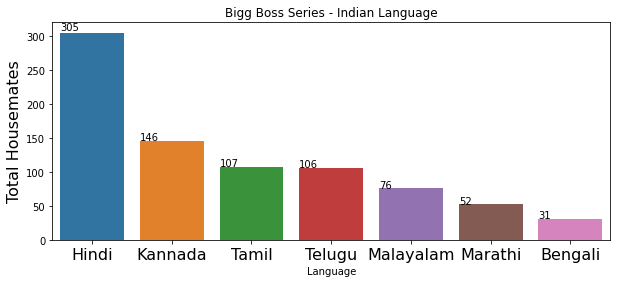

In [14]:
# Total number of Bigg Boss housemates
fig = plt.figure(figsize=(10, 4))
ax = sns.countplot(x='Language', data=bigg_boss, order=bigg_boss['Language'].value_counts().index)
ax.set_title('Bigg Boss Series - Indian Language')
plt.xticks(fontsize=16)
plt.ylabel("Total Housemates", fontsize=16)
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

## In Bigg Boss India seasons, most of the housemates entered in first day/week

No     692
Yes    131
Name: Wild Card, dtype: int64 

No     84%
Yes    16%
Name: Wild Card, dtype: object 



<AxesSubplot:ylabel='Wild Card'>

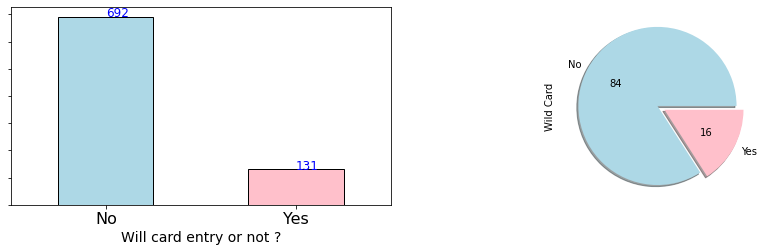

In [15]:
# Number of normal entries and wild card entries
print(bigg_boss['Wild Card'].value_counts(), "\n")
print(round(bigg_boss['Wild Card'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'), "\n")

plt.figure(figsize=(15, 8))
ax1=plt.subplot(221)
bigg_boss['Wild Card'].value_counts().plot(kind='bar',color=["lightblue","pink"],ec="k")
plt.xlabel("Will card entry or not ?", fontsize=14)
plt.xticks(rotation=0)
plt.setp(ax1.get_yticklabels(), visible=False)
plt.xticks(fontsize=16)
for x,y in enumerate(bigg_boss['Wild Card'].value_counts()):
    plt.annotate(y,(x,y),fontsize=12,color="blue")
    
ax2=plt.subplot(222)
bigg_boss['Wild Card'].value_counts().plot(kind='pie',autopct='%.0f',explode = (0,0.10),colors=["lightblue","pink"],shadow=True)

In [16]:
# Common people has many professions, so clubbing them into one category
bigg_boss['Profession'] = bigg_boss['Profession'].fillna('UNKNOWN')
bigg_boss.loc[bigg_boss['Profession'].str.contains('Commoner'),'Profession'] = 'Commoner'

## Number of film actresses entered into the Bigg Boss houses, are more when compared to other professions

Actress                  180
Actor                    133
Soap Actress              67
Model                     62
Singer                    52
Soap Actor                42
Commoner                  40
TV Anchor                 26
Reality Show Alumni       22
Social Media Star         21
Comedian                  19
Radio Jockey              17
Choreographer             14
News Presenter            14
Sports Person              9
Film Director              8
Activist                   8
Video Jockey               7
International Star         6
Politician                 6
Pageant Winner             6
Producer                   5
Dancer                     4
Swamiji                    4
LGBT                       4
Controversial Fame         4
Musician                   3
Wrestler                   3
Businessman                3
Lyricist                   2
Journalist                 2
Doctor                     2
Folk Artist                2
Fashion Designer           2
Stage Actress 

Text(0, 0.5, 'Count')

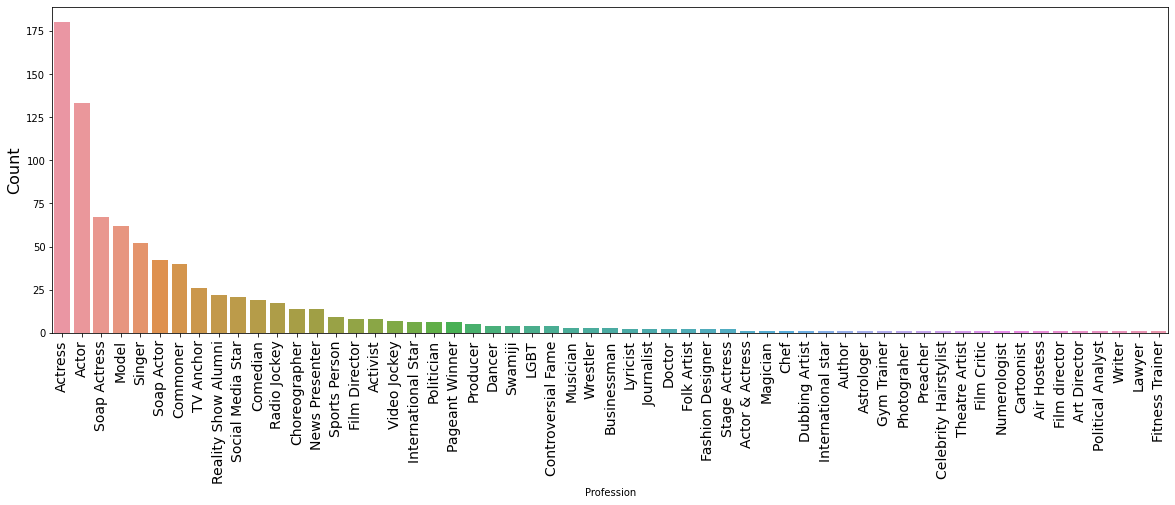

In [17]:
# Participant's Profession
print(bigg_boss['Profession'].value_counts())
fig = plt.figure(figsize=(20, 6))
sns.countplot(x='Profession', data=bigg_boss, order=bigg_boss['Profession'].value_counts().index)
plt.xticks(fontsize=14)
plt.xticks(rotation=90)
plt.ylabel("Count", fontsize=16)

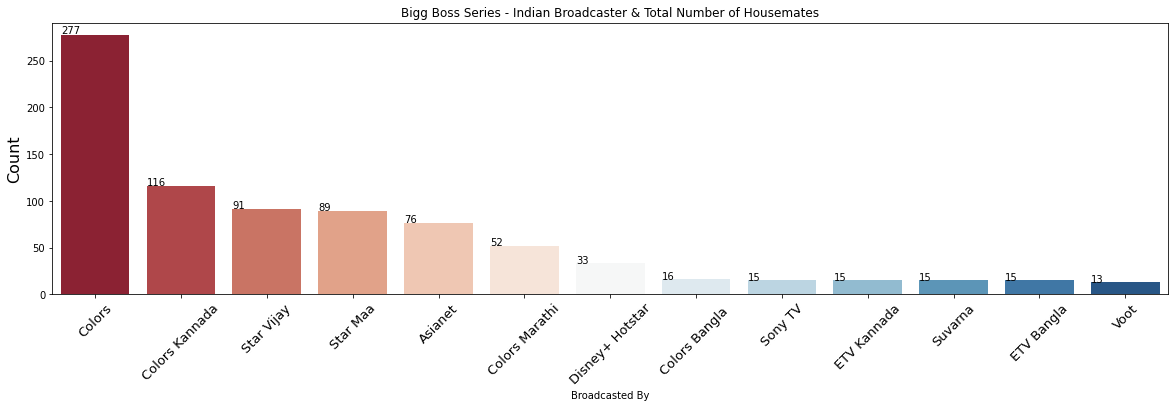

In [18]:
# Broadcaster
fig = plt.figure(figsize=(20, 5))
ax = sns.countplot(x='Broadcasted By', data=bigg_boss, palette='RdBu', order=bigg_boss['Broadcasted By'].value_counts().index)
ax.set_title('Bigg Boss Series - Indian Broadcaster & Total Number of Housemates')
plt.xticks(fontsize=13)
plt.ylabel("Count", fontsize=16)
plt.xticks(rotation=45)
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

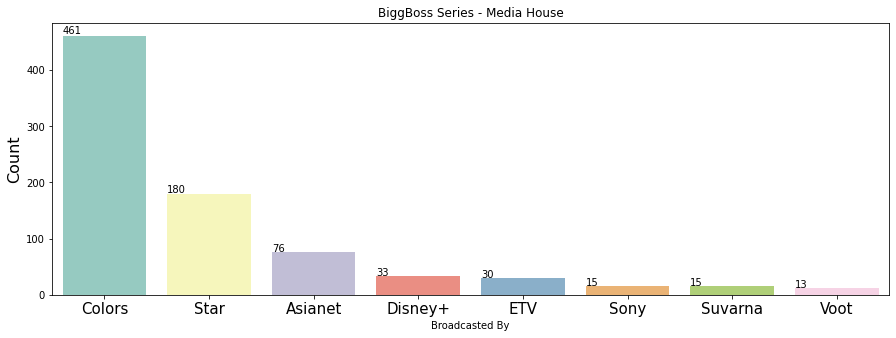

In [19]:
fig = plt.figure(figsize=(15, 5))
ax = sns.countplot(bigg_boss['Broadcasted By'].str.split().str.get(0), data=bigg_boss, palette='Set3', order=bigg_boss['Broadcasted By'].str.split().str.get(0).value_counts().index)
ax.set_title('BiggBoss Series - Media House')
plt.xticks(fontsize=15)
plt.ylabel("Count", fontsize=16)
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

## Salman Khan hosted most number of seasons (in Bigg Boss Hindi), Sudeep is next on the list

In [20]:
# Bigg Boss main hosts and number of seasons they hosted
bigg_boss.groupby('Host Name')['Season Number'].nunique().nlargest(25)

Host Name
Salman Khan            12
Sudeep                  8
Kamal Haasan            6
Mohanlal                4
Nagarjuna               4
Mahesh Manjrekar        3
Mithun Chakraborthy     2
Amitabh Bachchan        1
Arshad Warsi            1
Farah Khan              1
Jr. NTR                 1
Karan Johar             1
Nani                    1
Shilpa Shetty           1
Name: Season Number, dtype: int64

In [21]:
# Temporary or Guest host who hosted the week-end episodes
bigg_boss.groupby('Guest Host Name')['Season Number'].nunique().nlargest(10)

Guest Host Name
Ramya Krishnan       2
Farah Khan           1
Samantha             1
Sanjay Dutt          1
Siddhartha Jadhav    1
Simbu                1
Name: Season Number, dtype: int64

## In all Bigg Boss competitions, in languages and in all seasons, Female contestants are more

Female         431
Male           385
Transgender      6
Couple           1
Name: Gender, dtype: int64 

Female         52%
Male           47%
Transgender     1%
Couple          0%
Name: Gender, dtype: object


Text(0, 0.5, 'Count')

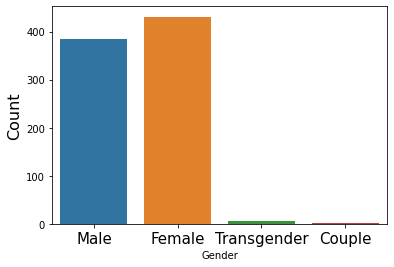

In [22]:
# Housemate's Gender
print(bigg_boss['Gender'].value_counts(), "\n")

# In percentage
print(round(bigg_boss['Gender'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'))

sns.countplot(data = bigg_boss, x = 'Gender')
plt.xticks(fontsize=15)
plt.ylabel("Count", fontsize=16)

### Only 6 Transgenders (LGBT) participated in all Indian languages

In [23]:
# Maximum TRP of Bigg Boss India seasons (Big Brother in India)
print("Maximum TRP", bigg_boss['Average TRP'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Average TRP']==bigg_boss['Average TRP'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Maximum TRP 20.1 

Language Season Number
  Telugu             4


In [24]:
# Smallest season of Indian Bigg Boss seasons
print("Smallest season", bigg_boss['Season Length'].min(), "days \n")
print(bigg_boss.loc[bigg_boss['Season Length']==bigg_boss['Season Length'].min()][["Language","Season Number"]].head(1).to_string(index=False))

Smallest season 28 days 

Language Season Number
   Hindi     Halla Bol


In [25]:
# Longest season of Bigg Boss Indian seasons
print("Longest season", bigg_boss['Season Length'].max(), "days \n")
print(bigg_boss.loc[bigg_boss['Season Length']==bigg_boss['Season Length'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Longest season 143 days 

Language Season Number
   Hindi            14


## Shark Tank India data set https://www.kaggle.com/thirumani/shark-tank-india

In [26]:
print("Maximum number of contestants in one season:", bigg_boss['Number of Housemates'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of Housemates']==bigg_boss['Number of Housemates'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Maximum number of contestants in one season: 24 

Language Season Number
   Hindi            15


In [27]:
print("Maximum number of evictions faced in one season:", bigg_boss['Number of Evictions Faced'].max(), "\n")
print("\nTop 3 contestants who faced maximum number of evictions\n")
print(bigg_boss.loc[bigg_boss['Number of Evictions Faced']>=bigg_boss['Number of Evictions Faced'].max()-3][["Language","Season Number","Name","Number of Evictions Faced"]].head(3).sort_values("Number of Evictions Faced",ascending=False).to_string(index=False))

Maximum number of evictions faced in one season: 17 


Top 3 contestants who faced maximum number of evictions

Language Season Number               Name  Number of Evictions Faced
   Hindi            14      Rubina Dilaik                         17
 Kannada             8 Prashanth Sambargi                         15
   Hindi            14       Rahul Vaidya                         14


In [28]:
bigg_boss['Season Length in weeks'] = round(bigg_boss['Season Length']/7,0).astype(pd.Int32Dtype())
bigg_boss['Evictions Faced Percentage'] = round(bigg_boss['Number of Evictions Faced']/bigg_boss['Season Length in weeks']*100,0).astype(pd.Int32Dtype())
print("Maximum percentage of evictions faced in one season:", bigg_boss['Evictions Faced Percentage'].max(), "%\n")
print("\nTop 4 contestants who faced maximum percentage of evictions (they were in nominations almost every week)\n")
print(bigg_boss.loc[bigg_boss['Evictions Faced Percentage']>=bigg_boss['Evictions Faced Percentage'].max()-15][["Language","Season Number","Name","Number of Evictions Faced","Season Length in weeks","Evictions Faced Percentage"]].head(5).sort_values("Evictions Faced Percentage",ascending=False).to_string(index=False))

Maximum percentage of evictions faced in one season: 100 %


Top 4 contestants who faced maximum percentage of evictions (they were in nominations almost every week)

 Language Season Number               Name  Number of Evictions Faced  Season Length in weeks  Evictions Faced Percentage
    Hindi     Halla Bol      Dimpy Ganguly                          4                       4                         100
  Kannada             8 Prashanth Sambargi                         15                      17                          88
Malayalam             3         Sai Vishnu                         12                      14                          86
    Hindi            14      Rubina Dilaik                         17                      20                          85


In [29]:
print("Maximum number of re-entries:", bigg_boss['Number of re-entries'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of re-entries']>=bigg_boss['Number of re-entries'].max()-1][["Language","Season Number","Name","Number of re-entries"]].head(5).sort_values("Number of re-entries",ascending=False).to_string(index=False))

Maximum number of re-entries: 3 

Language Season Number         Name  Number of re-entries
   Hindi            14  Vikas Gupta                     3
  Telugu             1 Mumaith Khan                     2
  Telugu             2  Nutan Naidu                     2


In [30]:
print("Maximum number of times elected as captain:", bigg_boss['Number of times elected as Captain'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of times elected as Captain']>=bigg_boss['Number of times elected as Captain'].max()-1][["Language","Season Number","Name","Number of times elected as Captain"]].head(6).sort_values("Number of times elected as Captain",ascending=False).to_string(index=False))

Maximum number of times elected as captain: 5 

 Language Season Number           Name  Number of times elected as Captain
    Hindi            12    Surbhi Rana                                   5
    Hindi             9  Prince Narula                                   4
    Hindi            10 Manveer Gurjar                                   4
Malayalam             2  Saju Navodaya                                   4


In [31]:
# Many contestants entered via wild card, but 21 people managed to go to Finale
print(bigg_boss.loc[(bigg_boss['Wild Card']=='Yes') & (bigg_boss['Finalist']==1), 'Finalist'].value_counts())
bigg_boss.loc[(bigg_boss['Wild Card']=='Yes') & (bigg_boss['Finalist']==1), :]

1    21
Name: Finalist, dtype: Int64


,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
44,Hindi,3,Pravesh Rana,Model,Male,NaT,NaT,12,Yes,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,0.0,Colors,2.83,NaN,NaN,4,0,0,<NA>,1,0.0,12,33
59,Hindi,4,Dalip Singh Rana (Khali),Wrestler,Male,NaT,2011-01-08,14,Yes,96,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,4.95,NaN,NaN,2,0,2,<NA>,1,0.0,14,14
60,Hindi,4,Dolly Bindra,Actress,Female,NaT,2011-01-08,14,Yes,96,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,4.95,NaN,NaN,4,0,1,<NA>,1,0.0,14,29
75,Hindi,5,Amar Upadhyay,Actor,Male,NaT,2012-01-07,14,Yes,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,4.19,NaN,NaN,7,0,1,<NA>,1,0.0,14,50
76,Hindi,5,Siddharth Bhardwaj,Reality Show Alumni,Male,NaT,2012-01-07,14,Yes,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,4.19,NaN,NaN,5,0,0,<NA>,1,0.0,14,36
77,Hindi,5,Akashdeep Saigal,Actor,Male,NaT,2012-01-07,14,Yes,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,4.19,NaN,NaN,5,0,1,<NA>,1,0.0,14,36
96,Hindi,6,Imam Siddique,Reality Show Alumni,Male,NaT,2013-01-12,14,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,3.81,NaN,NaN,6,1,1,<NA>,1,0.0,14,43
115,Hindi,7,Ajaz Khan,Actor,Male,NaT,2013-12-28,15,Yes,105,20,2013-09-15,2013-12-28,Salman Khan,NaN,0.0,Colors,4.40,NaN,NaN,7,0,0,<NA>,1,0.0,15,47
133,Hindi,8,Ali Quli Mirza,Singer,Male,NaT,2015-01-03,15,Yes,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0.0,Colors,3.77,NaN,NaN,6,0,1,<NA>,1,0.0,15,40
135,Hindi,8,Dimpy Ganguly,TV Anchor,Female,NaT,2015-01-03,15,Yes,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0.0,Colors,3.77,NaN,NaN,5,0,1,<NA>,1,0.0,15,33


In [32]:
# Number of Wild card entries went to Finale, as per Language
bigg_boss.loc[(bigg_boss['Wild Card']=='Yes') & (bigg_boss['Finalist']==1), 'Language'].value_counts()

Hindi        14
Tamil         3
Marathi       2
Telugu        1
Malayalam     1
Name: Language, dtype: int64

In [33]:
# Persons who participated in more than one season (in same/different languages)
print(bigg_boss.groupby('Name')['Season Number'].nunique().nlargest(41))
bigg_boss[bigg_boss.groupby('Name')['Season Number'].transform('size')>1] [["Name", "Language", "Season Number"]].sort_values(by=['Name','Season Number'], ascending=True)

Name
Rakhi Sawant               3
Shamita Shetty             3
Vikas Gupta                3
Abhinay Vaddi              2
Abhirami Venkatachalam     2
Ajaz Khan                  2
Akhil Sarthak              2
Ali Quli Mirza             2
Anitha Sampath             2
Ariyana Glory              2
Arshi Khan                 2
Ashu Reddy                 2
Balaji Murugadoss          2
Bindu Madhavi              2
Devoleena Bhattacharjee    2
Dimpy Ganguly              2
Gautam Gulati              2
Hamida Khatoon             2
Karishma Tanna             2
Mahek Chahal               2
Mahesh Vitta               2
Manu Punjabi               2
Maria Juliana              2
Megha Dhade                2
Mumaith Khan               2
Nataraj                    2
Neha Bhasin                2
Nishant Bhat               2
Pratik Sehajpal            2
Pritam Singh               2
Rahul Mahajan              2
Ramya Pandian              2
Raqesh Bapat               2
Rashami Desai              2
Sana Khan

,Name,Language,Season Number
628,Abhinay Vaddi,Tamil,5
648,Abhinay Vaddi,Tamil,Ultimate
593,Abhirami Venkatachalam,Tamil,3
649,Abhirami Venkatachalam,Tamil,Ultimate
115,Ajaz Khan,Hindi,7
...,...,...,...
607,Vanitha Vijayakumar,Tamil,3
661,Vanitha Vijayakumar,Tamil,Ultimate
201,Vikas Gupta,Hindi,11
245,Vikas Gupta,Hindi,13


In [34]:
# Persons who participated in more than one language
bigg_boss.groupby('Name')['Language'].nunique().nlargest(2)

Name
Bindu Madhavi    2
Megha Dhade      2
Name: Language, dtype: int64

## About Winners only

In [35]:
print("Total Bigg Boss season winners", bigg_boss['Winner'].sum().astype(int), "(out of", bigg_boss['Finalist'].sum(), "finalists)")
# For Malayalam Season 2 winner was not declared

Total Bigg Boss season winners 42 (out of 197 finalists)


In [36]:
# All BB Winners
bigg_boss.loc[bigg_boss.Winner==1]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
8,Hindi,1,Rahul Roy,Actor,Male,2006-11-03,NaT,<NA>,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,10000000.0,Sony TV,2.72,NaN,NaN,4,0,0,<NA>,1,1.0,12,33
16,Hindi,2,Ashutosh Kaushik,Reality Show Alumni,Male,2008-08-17,NaT,<NA>,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,10000000.0,Colors,2.89,NaN,NaN,4,0,0,<NA>,1,1.0,14,29
42,Hindi,3,Vindu Dara Singh,Actor,Male,2009-10-04,NaT,<NA>,No,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,10000000.0,Colors,2.83,NaN,NaN,7,0,0,<NA>,1,1.0,12,58
57,Hindi,4,Shweta Tiwari,Soap Actress,Female,2010-10-03,NaT,<NA>,No,96,16,2010-10-03,2011-01-08,Salman Khan,NaN,10000000.0,Colors,4.95,NaN,NaN,4,0,2,<NA>,1,1.0,14,29
62,Hindi,5,Juhi Parmar,Soap Actress,Female,2011-10-02,NaT,<NA>,No,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,10000000.0,Colors,4.19,NaN,NaN,4,0,1,<NA>,1,1.0,14,29
92,Hindi,6,Urvashi Dholakia,Soap Actress,Female,2012-10-07,NaT,<NA>,No,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,5000000.0,Colors,3.81,NaN,NaN,6,0,1,<NA>,1,1.0,14,43
102,Hindi,7,Gauhar Khan,Actress,Female,2013-09-15,NaT,<NA>,No,105,20,2013-09-15,2013-12-28,Salman Khan,NaN,5000000.0,Colors,4.40,NaN,NaN,7,0,2,<NA>,1,1.0,15,47
121,Hindi,8,Gautam Gulati,Actor,Male,2014-09-21,NaT,<NA>,No,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,5000000.0,Colors,3.77,NaN,NaN,10,0,1,<NA>,1,1.0,15,67
140,Hindi,Halla Bol,Gautam Gulati,Actor,Male,2015-01-04,NaT,<NA>,No,28,10,2015-01-04,2015-01-31,Farah Khan,NaN,5000000.0,Colors,2.82,NaN,NaN,2,0,0,<NA>,1,1.0,4,50
154,Hindi,9,Prince Narula,Reality Show Alumni,Male,2015-10-11,NaT,<NA>,No,105,20,2015-10-11,2016-01-23,Salman Khan,NaN,5000000.0,Colors,2.90,NaN,NaN,6,0,4,<NA>,1,1.0,15,40


In [37]:
# Sum of prize money won by all BB Season winners/participants, in India
print(format_currency(bigg_boss['Prize Money (INR)'].sum(), 'INR', locale='en_IN').replace(".00", ""))

# 22 crores and 56 lakh rupees

₹22,56,00,000


In [38]:
# Profession of BB Season Winners
bigg_boss.loc[bigg_boss.Winner==1, 'Profession'].value_counts()

Actor                  12
Soap Actress            6
Actress                 6
Singer                  4
Reality Show Alumni     3
Soap Actor              3
Commoner                2
TV Anchor               2
Film Director           1
Comedian                1
Video Jockey            1
Model                   1
Name: Profession, dtype: int64

Male      30
Female    12
Name: Gender, dtype: int64 

Male      71%
Female    29%
Name: Gender, dtype: object


<AxesSubplot:ylabel='Gender'>

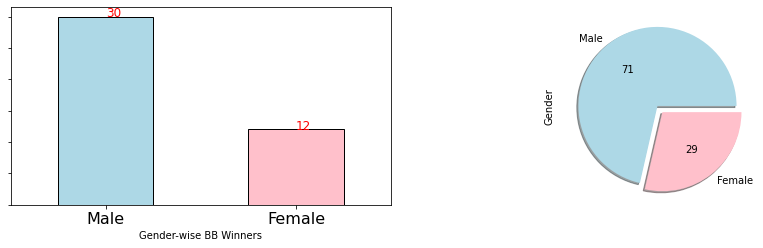

In [39]:
# Gender of Season title Winners
print(bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts(), '\n')

# In percentage
print(round(bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'))

plt.figure(figsize=(15,8))
ax1=plt.subplot(221)
bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts().plot(kind='bar',color=["lightblue","pink"],ec="k")
plt.xlabel("Gender-wise BB Winners")
plt.xticks(rotation=0)
plt.setp(ax1.get_yticklabels(), visible=False)
plt.xticks(fontsize=16)
for x,y in enumerate(bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts()):
    plt.annotate(y,(x,y),fontsize=12,color="Red")
    
ax2=plt.subplot(222)
bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts().plot(kind='pie',autopct='%.0f',explode = (0,0.10),colors=["lightblue","pink"],shadow=True)

## No wild card entry housemate won the Bigg Boss competition.

In [40]:
# Entry type of the Season Winners
bigg_boss.loc[bigg_boss.Winner==1, 'Wild Card'].value_counts()

No    42
Name: Wild Card, dtype: int64

In [41]:
bigg_boss.loc[bigg_boss.Winner==1, 'Season Length'].value_counts().sort_index()

# Length of the season - Number of Winners

28      1
42      1
70      1
84      1
86      1
90      1
95      1
96      1
97      2
98     10
100     1
105    12
106     2
112     2
113     1
117     1
121     1
140     1
143     1
Name: Season Length, dtype: int64

In [42]:
bigg_boss.loc[bigg_boss.Winner==1, 'Number of Housemates'].value_counts().sort_index()

# Number of Housemates in house - Number of Winners

10    1
13    1
15    6
16    3
17    5
18    9
19    6
20    8
22    2
24    1
Name: Number of Housemates, dtype: int64

In [43]:
# Number of eliminations or evictions faced by the Bigg Boss competition winners
bigg_boss.loc[bigg_boss.Winner==1, 'Number of Evictions Faced'].value_counts().sort_index()

# Number of eliminations faced - Number of Winners

2     1
4     7
5     5
6     6
7     7
8     1
9     7
10    1
11    2
12    3
17    1
Name: Number of Evictions Faced, dtype: Int64

In [44]:
# No re-entered contestant won Bigg Boss title
bigg_boss.loc[bigg_boss.Winner==1, 'Number of re-entries'].value_counts()

0    42
Name: Number of re-entries, dtype: Int64

In [45]:
# Bigg Boss title winners number of times elected as captain
bigg_boss.loc[bigg_boss.Winner==1, 'Number of times elected as Captain'].value_counts().sort_index()

# Number of times elected as Captain - Number of winners

0    13
1    12
2    12
3     1
4     2
Name: Number of times elected as Captain, dtype: Int64

## BB Telugu Seasons

In [46]:
lang='Telugu'

# All Bigg Boss Telugu Participants
bigg_boss.loc[(bigg_boss['Language']==lang)]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
451,Telugu,1,Aadarsh Balakrishna,Actor,Male,2017-07-16,2017-09-24,10,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",NaN,4,0,1,7,1,0.0,10,40
452,Telugu,1,Archana,Actress,Female,2017-07-16,2017-09-24,10,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",NaN,6,0,0,5,1,0.0,10,60
453,Telugu,1,Dhanraj,Comedian,Male,2017-07-16,2017-08-26,6,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",NaN,3,0,0,<NA>,0,0.0,10,30
454,Telugu,1,Hari Teja,Actress,Female,2017-07-16,2017-09-24,10,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",NaN,6,0,1,5,1,0.0,10,60
455,Telugu,1,Jyothi,Actress,Female,2017-07-16,2017-07-23,1,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",NaN,1,0,0,<NA>,0,0.0,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,Telugu,Non-Stop,Sarayu,Social Media Star,Female,2022-02-26,NaT,4,No,84,17,2022-02-26,2022-05-21,Nagarjuna,NaN,0.0,Disney+ Hotstar,NaN,"Telangana, Andhra Pradesh",NaN,3,0,0,<NA>,0,0.0,12,25
553,Telugu,Non-Stop,Shiva,TV Anchor,Male,2022-02-26,NaT,<NA>,No,84,17,2022-02-26,2022-05-21,Nagarjuna,NaN,NaN,Disney+ Hotstar,NaN,"Telangana, Andhra Pradesh",NaN,3,0,0,<NA>,<NA>,NaN,12,25
554,Telugu,Non-Stop,Sravanthi,TV Anchor,Female,2022-02-26,NaT,<NA>,No,84,17,2022-02-26,2022-05-21,Nagarjuna,NaN,NaN,Disney+ Hotstar,NaN,"Telangana, Andhra Pradesh",NaN,1,0,0,<NA>,<NA>,NaN,12,8
555,Telugu,Non-Stop,Shree Rapaka,Actress,Female,2022-02-26,NaT,2,No,84,17,2022-02-26,2022-05-21,Nagarjuna,NaN,0.0,Disney+ Hotstar,NaN,"Telangana, Andhra Pradesh",NaN,1,0,0,<NA>,0,0.0,12,8


In [47]:
# Bigg Boss Telugu Winners
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner']==1), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
464,Telugu,1,Siva Balaji,Actor,Male,2017-07-16,NaT,<NA>,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,5000000.0,Star Maa,15.0,"Telangana, Andhra Pradesh",NaN,4,0,2,8,1,1.0,10,40
474,Telugu,2,Kaushal Manda,Actor,Male,2018-06-10,NaT,<NA>,No,112,18,2018-06-10,2018-09-30,Nani,NaN,5000000.0,Star Maa,15.0,"Telangana, Andhra Pradesh",NaN,11,0,1,10,1,1.0,16,69
493,Telugu,3,Rahul Sipligunj,Singer,Male,2019-07-21,NaT,<NA>,No,105,17,2019-07-21,2019-11-03,Nagarjuna,Ramya Krishnan,5000000.0,Star Maa,18.1,"Telangana, Andhra Pradesh",NaN,12,0,0,9,1,1.0,15,80
502,Telugu,4,Abijeet,Actor,Male,2020-09-06,NaT,<NA>,No,105,19,2020-09-06,2020-12-20,Nagarjuna,Samantha,2500000.0,Star Maa,20.1,"Telangana, Andhra Pradesh",NaN,12,0,0,9,1,1.0,15,80
536,Telugu,5,Sunny,Video Jockey,Male,2021-09-05,NaT,<NA>,No,105,19,2021-09-05,2021-12-19,Nagarjuna,NaN,5000000.0,Star Maa,18.2,"Telangana, Andhra Pradesh",NaN,9,0,1,10,1,1.0,15,60


In [48]:
# Telugu Bigg Boss all seasons finalists
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Finalist']==1), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
451,Telugu,1,Aadarsh Balakrishna,Actor,Male,2017-07-16,2017-09-24,10,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",NaN,4,0,1,7,1,0.0,10,40
452,Telugu,1,Archana,Actress,Female,2017-07-16,2017-09-24,10,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",NaN,6,0,0,5,1,0.0,10,60
454,Telugu,1,Hari Teja,Actress,Female,2017-07-16,2017-09-24,10,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",NaN,6,0,1,5,1,0.0,10,60
464,Telugu,1,Siva Balaji,Actor,Male,2017-07-16,NaT,<NA>,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,5000000.0,Star Maa,15.0,"Telangana, Andhra Pradesh",NaN,4,0,2,8,1,1.0,10,40
466,Telugu,1,Navdeep,Actor,Male,2017-08-14,2017-09-24,10,Yes,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",NaN,3,0,1,9,1,0.0,10,30
470,Telugu,2,Deepti Nallamuthu,TV Anchor,Female,2018-06-10,2018-09-30,16,No,112,18,2018-06-10,2018-09-30,Nani,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",NaN,11,0,1,5,1,0.0,16,69
473,Telugu,2,Geetha Madhuri,Singer,Female,2018-06-10,2018-09-30,16,No,112,18,2018-06-10,2018-09-30,Nani,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",NaN,7,0,2,8,1,0.0,16,44
474,Telugu,2,Kaushal Manda,Actor,Male,2018-06-10,NaT,<NA>,No,112,18,2018-06-10,2018-09-30,Nani,NaN,5000000.0,Star Maa,15.0,"Telangana, Andhra Pradesh",NaN,11,0,1,10,1,1.0,16,69
478,Telugu,2,Samrat Reddy,Actor,Male,2018-06-10,2018-09-30,16,No,112,18,2018-06-10,2018-09-30,Nani,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",NaN,3,0,1,5,1,0.0,16,19
481,Telugu,2,Tanish Alladi,Actor,Male,2018-06-10,2018-09-30,16,No,112,18,2018-06-10,2018-09-30,Nani,NaN,0.0,Star Maa,15.0,"Telangana, Andhra Pradesh",NaN,5,0,2,7,1,0.0,16,31


In [49]:
# Number of finalists gender wise, in each BB Telugu season
bigg_boss[(bigg_boss['Language']==lang) & (bigg_boss['Finalist']==1)].groupby('Gender')['Season Number'].value_counts().sort_index()

Gender  Season Number
Female  1                2
        2                2
        3                1
        4                2
        5                1
Male    1                3
        2                3
        3                4
        4                3
        5                4
Name: Season Number, dtype: int64

## Bigg Boss India data set visualizations/infographics at Tableau Public -
## http://public.tableau.com/app/profile/satya.thirumani/viz/BiggBossIndia_16434338263440/BBStory

In [50]:
IFrame('https://public.tableau.com/views/BiggBossIndia_16434338263440/BBStory?:language=en-US&:display_count=n&:origin=viz_share_link', width=1000, height=1000)

In [51]:
# Bigg Boss Telugu current season participants
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Season Number']=='Non-Stop'), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
540,Telugu,Non-Stop,Ajay Kumar,Actor,Male,2022-02-26,NaT,<NA>,No,84,17,2022-02-26,2022-05-21,Nagarjuna,NaN,NaN,Disney+ Hotstar,NaN,"Telangana, Andhra Pradesh",NaN,2,0,0,<NA>,<NA>,NaN,12,17
541,Telugu,Non-Stop,Akhil Sarthak,Soap Actor,Male,2022-02-26,NaT,<NA>,No,84,17,2022-02-26,2022-05-21,Nagarjuna,NaN,NaN,Disney+ Hotstar,NaN,"Telangana, Andhra Pradesh",NaN,2,0,0,<NA>,<NA>,NaN,12,17
542,Telugu,Non-Stop,Anil Rathod,Model,Male,2022-02-26,NaT,<NA>,No,84,17,2022-02-26,2022-05-21,Nagarjuna,NaN,NaN,Disney+ Hotstar,NaN,"Telangana, Andhra Pradesh",NaN,2,0,1,<NA>,<NA>,NaN,12,17
543,Telugu,Non-Stop,Ariyana Glory,TV Anchor,Female,2022-02-26,NaT,<NA>,No,84,17,2022-02-26,2022-05-21,Nagarjuna,NaN,NaN,Disney+ Hotstar,NaN,"Telangana, Andhra Pradesh",NaN,4,0,0,<NA>,<NA>,NaN,12,33
544,Telugu,Non-Stop,Ashu Reddy,Social Media Star,Female,2022-02-26,NaT,<NA>,No,84,17,2022-02-26,2022-05-21,Nagarjuna,NaN,NaN,Disney+ Hotstar,NaN,"Telangana, Andhra Pradesh",NaN,1,0,0,<NA>,<NA>,NaN,12,8
545,Telugu,Non-Stop,Bindu Madhavi,Actress,Female,2022-02-26,NaT,<NA>,No,84,17,2022-02-26,2022-05-21,Nagarjuna,NaN,NaN,Disney+ Hotstar,NaN,"Telangana, Andhra Pradesh",NaN,2,0,0,<NA>,<NA>,NaN,12,17
546,Telugu,Non-Stop,RJ Chaitu,Radio Jockey,Male,2022-02-26,NaT,3,No,84,17,2022-02-26,2022-05-21,Nagarjuna,NaN,0.0,Disney+ Hotstar,NaN,"Telangana, Andhra Pradesh",NaN,2,0,0,<NA>,0,0.0,12,17
547,Telugu,Non-Stop,Hamida Khatoon,Actress,Female,2022-02-26,NaT,<NA>,No,84,17,2022-02-26,2022-05-21,Nagarjuna,NaN,NaN,Disney+ Hotstar,NaN,"Telangana, Andhra Pradesh",NaN,3,0,0,<NA>,<NA>,NaN,12,25
548,Telugu,Non-Stop,Mahesh Vitta,Actor,Male,2022-02-26,NaT,<NA>,No,84,17,2022-02-26,2022-05-21,Nagarjuna,NaN,NaN,Disney+ Hotstar,NaN,"Telangana, Andhra Pradesh",NaN,2,0,0,<NA>,<NA>,NaN,12,17
549,Telugu,Non-Stop,Mitraaw Sharma,Actress,Female,2022-02-26,NaT,<NA>,No,84,17,2022-02-26,2022-05-21,Nagarjuna,NaN,NaN,Disney+ Hotstar,NaN,"Telangana, Andhra Pradesh",NaN,4,0,0,<NA>,<NA>,NaN,12,33


In [52]:
# Bigg Boss Telugu Housemate's Gender
print(bigg_boss.loc[(bigg_boss['Language']==lang), 'Gender'].value_counts(), "\n")

Female         55
Male           49
Transgender     2
Name: Gender, dtype: int64 



In [53]:
print("\nTop 6 Telugu contestants who faced maximum number of evictions\n")
tmax=bigg_boss.loc[(bigg_boss['Language']==lang), 'Number of Evictions Faced'].max()
print(bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Number of Evictions Faced']>=tmax-1)][["Season Number","Name","Number of Evictions Faced"]].head(8).sort_values("Number of Evictions Faced",ascending=False).to_string(index=False))


Top 6 Telugu contestants who faced maximum number of evictions

Season Number              Name  Number of Evictions Faced
            3   Rahul Sipligunj                         12
            4           Abijeet                         12
            4      Monal Gajjar                         12
            2 Deepti Nallamuthu                         11
            2     Kaushal Manda                         11
            5    Siri Hanumanth                         11


In [54]:
print("\nTop 4 Telugu contestants who faced maximum percentage of evictions (they were in nominations almost every week)\n")
tpmax=bigg_boss.loc[(bigg_boss['Language']==lang), 'Evictions Faced Percentage'].max()
print(bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Evictions Faced Percentage']>=tpmax-10)][["Season Number","Name","Number of Evictions Faced","Season Length in weeks","Evictions Faced Percentage"]].head(6).sort_values("Evictions Faced Percentage",ascending=False).to_string(index=False))


Top 4 Telugu contestants who faced maximum percentage of evictions (they were in nominations almost every week)

Season Number            Name  Number of Evictions Faced  Season Length in weeks  Evictions Faced Percentage
            3 Rahul Sipligunj                         12                      15                          80
            4         Abijeet                         12                      15                          80
            4    Monal Gajjar                         12                      15                          80
            5  Siri Hanumanth                         11                      15                          73


## Preparing Data for ML modelling

In [55]:
# Handling NULL values
bigg_boss.isnull().sum()

Language                                0
Season Number                           0
Name                                    0
Profession                              0
Gender                                  0
Entry Date                            120
Elimination Date                      671
Elimination Week Number               156
Wild Card                               0
Season Length                           0
Number of Housemates                    0
Season Start Date                       0
Season End Date                         0
Host Name                               0
Guest Host Name                       697
Prize Money (INR)                      37
Broadcasted By                          0
Average TRP                           292
Most Viewed States                    305
OTT Season                            794
Number of Evictions Faced              35
Number of re-entries                   17
Number of times elected as Captain     56
Social Media Popularity           

In [56]:
# Removing records where Name field is empty
bigg_boss = bigg_boss.loc[bigg_boss.Name.notnull()]
bigg_boss.reset_index(drop=True,inplace=True)

In [57]:
# Contestant might have faced at least one eviction, so filling NaN with 'Number of Evictions Faced' with 1
bigg_boss['Number of Evictions Faced'] = bigg_boss['Number of Evictions Faced'].fillna(1)

# Number of re-entries are very less, so filling NULLs in 'Number of re-entries' with 0
bigg_boss['Number of re-entries'] = bigg_boss['Number of re-entries'].fillna(0)

# Filling blank values in 'Average TRP' column with average
bigg_boss['Average TRP'] = bigg_boss['Average TRP'].fillna(bigg_boss['Average TRP'].mean())

# Filling NULLs in 'Number of times elected as Captain' with 0
bigg_boss['Number of times elected as Captain'] = bigg_boss['Number of times elected as Captain'].fillna(0)

In [58]:
bigg_boss['Season Starting Year'] = bigg_boss['Season Start Date'].dt.year.astype(pd.Int32Dtype())
bigg_boss['Season Ending Year'] = bigg_boss['Season End Date'].dt.year.astype(pd.Int32Dtype())
bigg_boss['Season Starting Quarter'] = bigg_boss['Season Start Date'].dt.quarter.astype(pd.Int32Dtype())
bigg_boss['Season Ending Quarter'] = bigg_boss['Season End Date'].dt.quarter.astype(pd.Int32Dtype())
bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Language                            823 non-null    object        
 1   Season Number                       823 non-null    object        
 2   Name                                823 non-null    object        
 3   Profession                          823 non-null    object        
 4   Gender                              823 non-null    object        
 5   Entry Date                          703 non-null    datetime64[ns]
 6   Elimination Date                    152 non-null    datetime64[ns]
 7   Elimination Week Number             667 non-null    Int32         
 8   Wild Card                           823 non-null    object        
 9   Season Length                       823 non-null    int64         
 10  Number of Housemates      

In [59]:
bigg_boss.head()

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
0,Hindi,1,Amit Sadh,Soap Actor,Male,2006-11-03,NaT,10,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,NaN,NaN,3,0,0,<NA>,0,0.0,12,25,2006,2007,4,1
1,Hindi,1,Anupama Verma,Model,Female,2006-11-03,NaT,5,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,NaN,NaN,1,0,0,<NA>,0,0.0,12,8,2006,2007,4,1
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,2006-11-03,NaT,4,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,NaN,NaN,1,0,0,<NA>,0,0.0,12,8,2006,2007,4,1
3,Hindi,1,Bobby Darling,LGBT,Transgender,2006-11-03,NaT,1,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,NaN,NaN,1,0,0,<NA>,0,0.0,12,8,2006,2007,4,1
4,Hindi,1,Carol Gracias,Model,Female,2006-11-03,2007-01-26,12,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,NaN,NaN,6,0,0,<NA>,1,0.0,12,50,2006,2007,4,1


In [60]:
bigg_boss.tail()

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
818,Malayalam,4,Robin Radhakrishnan,Doctor,Male,2022-03-27,NaT,<NA>,No,107,17,2022-03-27,2022-07-07,Mohanlal,NaN,NaN,Asianet,8.707476,Kerala,NaN,1,0,0,<NA>,<NA>,NaN,15,<NA>,2022,2022,1,3
819,Malayalam,4,Ronson Vincent,Soap Actor,Male,2022-03-27,NaT,<NA>,No,107,17,2022-03-27,2022-07-07,Mohanlal,NaN,NaN,Asianet,8.707476,Kerala,NaN,1,0,0,<NA>,<NA>,NaN,15,<NA>,2022,2022,1,3
820,Malayalam,4,Shalini Nair,Video Jockey,Female,2022-03-27,NaT,<NA>,No,107,17,2022-03-27,2022-07-07,Mohanlal,NaN,NaN,Asianet,8.707476,Kerala,NaN,1,0,0,<NA>,<NA>,NaN,15,<NA>,2022,2022,1,3
821,Malayalam,4,Sooraj Thelakkad,Actor,Male,2022-03-27,NaT,<NA>,No,107,17,2022-03-27,2022-07-07,Mohanlal,NaN,NaN,Asianet,8.707476,Kerala,NaN,1,0,0,<NA>,<NA>,NaN,15,<NA>,2022,2022,1,3
822,Malayalam,4,Suchithra Nair,Soap Actress,Female,2022-03-27,NaT,<NA>,No,107,17,2022-03-27,2022-07-07,Mohanlal,NaN,NaN,Asianet,8.707476,Kerala,NaN,1,0,0,<NA>,<NA>,NaN,15,<NA>,2022,2022,1,3


In [61]:
# Updating last week-end elimination/entries manually
#bigg_boss.iloc[550, 25] = 0

In [62]:
train = bigg_boss.loc[(bigg_boss['Winner'].notnull()), :]
train.sample(10)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
713,Marathi,3,Vishal Nikam,Soap Actor,Male,2021-09-19,NaT,<NA>,No,98,17,2021-09-19,2021-12-26,Mahesh Manjrekar,Siddhartha Jadhav,2000000.0,Colors Marathi,8.707476,Maharashtra,NaN,9,0,0,<NA>,1,1.0,14,64,2021,2021,3,4
709,Marathi,3,Surekha Kudachi,Soap Actress,Female,2021-09-19,NaT,4,No,98,17,2021-09-19,2021-12-26,Mahesh Manjrekar,Siddhartha Jadhav,0.0,Colors Marathi,8.707476,Maharashtra,NaN,2,0,0,<NA>,0,0.0,14,14,2021,2021,3,4
419,Kannada,7,Harish Raj,Actor,Male,2019-10-13,NaT,16,No,113,20,2019-10-13,2020-02-02,Sudeep,NaN,0.0,Colors Kannada,8.707476,Karnataka,NaN,7,0,2,<NA>,0,0.0,16,44,2019,2020,4,1
208,Hindi,12,Karanvir Bohra,Soap Actor,Male,2018-09-16,2018-12-30,15,No,105,20,2018-09-16,2018-12-30,Salman Khan,NaN,0.0,Colors,4.990000,NaN,NaN,10,0,1,5,1,0.0,15,67,2018,2018,3,4
418,Kannada,7,Gurulinga Swamy,Swamiji,Male,2019-10-13,NaT,1,No,113,20,2019-10-13,2020-02-02,Sudeep,NaN,0.0,Colors Kannada,8.707476,Karnataka,NaN,1,0,0,<NA>,0,0.0,16,6,2019,2020,4,1
767,Malayalam,2,Arya Rohit,Actress,Female,2020-01-05,NaT,<NA>,No,75,23,2020-01-05,2020-03-20,Mohanlal,NaN,0.0,Asianet,11.030000,Kerala,NaN,5,0,0,<NA>,0,0.0,11,45,2020,2020,1,1
473,Telugu,2,Geetha Madhuri,Singer,Female,2018-06-10,2018-09-30,16,No,112,18,2018-06-10,2018-09-30,Nani,NaN,0.0,Star Maa,15.000000,"Telangana, Andhra Pradesh",NaN,7,0,2,8,1,0.0,16,44,2018,2018,2,3
376,Kannada,5,Jagan Chandrashekhar,Soap Actor,Male,2017-10-15,NaT,9,No,106,20,2017-10-15,2018-01-28,Sudeep,NaN,0.0,Colors Kannada,8.707476,Karnataka,NaN,6,0,1,<NA>,0,0.0,15,40,2017,2018,4,1
804,Malayalam,3,Angel Thomas,Model,Female,NaT,NaT,4,Yes,95,18,2021-02-14,2021-05-20,Mohanlal,NaN,0.0,Asianet,12.400000,Kerala,NaN,1,0,0,<NA>,0,0.0,14,7,2021,2021,1,2
120,Hindi,8,Diandra Soares,Model,Female,2014-09-21,NaT,12,No,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0.0,Colors,3.770000,NaN,NaN,4,0,1,<NA>,0,0.0,15,27,2014,2015,3,1


In [63]:
test = bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner'].isnull()), :]
test

# Participants who are still in current Bigg Boss Telugu season

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
540,Telugu,Non-Stop,Ajay Kumar,Actor,Male,2022-02-26,NaT,<NA>,No,84,17,2022-02-26,2022-05-21,Nagarjuna,NaN,NaN,Disney+ Hotstar,8.707476,"Telangana, Andhra Pradesh",NaN,2,0,0,<NA>,<NA>,NaN,12,17,2022,2022,1,2
541,Telugu,Non-Stop,Akhil Sarthak,Soap Actor,Male,2022-02-26,NaT,<NA>,No,84,17,2022-02-26,2022-05-21,Nagarjuna,NaN,NaN,Disney+ Hotstar,8.707476,"Telangana, Andhra Pradesh",NaN,2,0,0,<NA>,<NA>,NaN,12,17,2022,2022,1,2
542,Telugu,Non-Stop,Anil Rathod,Model,Male,2022-02-26,NaT,<NA>,No,84,17,2022-02-26,2022-05-21,Nagarjuna,NaN,NaN,Disney+ Hotstar,8.707476,"Telangana, Andhra Pradesh",NaN,2,0,1,<NA>,<NA>,NaN,12,17,2022,2022,1,2
543,Telugu,Non-Stop,Ariyana Glory,TV Anchor,Female,2022-02-26,NaT,<NA>,No,84,17,2022-02-26,2022-05-21,Nagarjuna,NaN,NaN,Disney+ Hotstar,8.707476,"Telangana, Andhra Pradesh",NaN,4,0,0,<NA>,<NA>,NaN,12,33,2022,2022,1,2
544,Telugu,Non-Stop,Ashu Reddy,Social Media Star,Female,2022-02-26,NaT,<NA>,No,84,17,2022-02-26,2022-05-21,Nagarjuna,NaN,NaN,Disney+ Hotstar,8.707476,"Telangana, Andhra Pradesh",NaN,1,0,0,<NA>,<NA>,NaN,12,8,2022,2022,1,2
545,Telugu,Non-Stop,Bindu Madhavi,Actress,Female,2022-02-26,NaT,<NA>,No,84,17,2022-02-26,2022-05-21,Nagarjuna,NaN,NaN,Disney+ Hotstar,8.707476,"Telangana, Andhra Pradesh",NaN,2,0,0,<NA>,<NA>,NaN,12,17,2022,2022,1,2
547,Telugu,Non-Stop,Hamida Khatoon,Actress,Female,2022-02-26,NaT,<NA>,No,84,17,2022-02-26,2022-05-21,Nagarjuna,NaN,NaN,Disney+ Hotstar,8.707476,"Telangana, Andhra Pradesh",NaN,3,0,0,<NA>,<NA>,NaN,12,25,2022,2022,1,2
548,Telugu,Non-Stop,Mahesh Vitta,Actor,Male,2022-02-26,NaT,<NA>,No,84,17,2022-02-26,2022-05-21,Nagarjuna,NaN,NaN,Disney+ Hotstar,8.707476,"Telangana, Andhra Pradesh",NaN,2,0,0,<NA>,<NA>,NaN,12,17,2022,2022,1,2
549,Telugu,Non-Stop,Mitraaw Sharma,Actress,Female,2022-02-26,NaT,<NA>,No,84,17,2022-02-26,2022-05-21,Nagarjuna,NaN,NaN,Disney+ Hotstar,8.707476,"Telangana, Andhra Pradesh",NaN,4,0,0,<NA>,<NA>,NaN,12,33,2022,2022,1,2
551,Telugu,Non-Stop,Nataraj,Choreographer,Male,2022-02-26,NaT,<NA>,No,84,17,2022-02-26,2022-05-21,Nagarjuna,NaN,NaN,Disney+ Hotstar,8.707476,"Telangana, Andhra Pradesh",NaN,3,0,1,<NA>,<NA>,NaN,12,25,2022,2022,1,2


In [64]:
BB_telugu_participant = test[['Name']]
BB_telugu_participant.reset_index(drop=True, inplace=True)
BB_telugu_participant

,Name
0,Ajay Kumar
1,Akhil Sarthak
2,Anil Rathod
3,Ariyana Glory
4,Ashu Reddy
5,Bindu Madhavi
6,Hamida Khatoon
7,Mahesh Vitta
8,Mitraaw Sharma
9,Nataraj


In [65]:
train.drop(["Name","Entry Date","Elimination Date","Season Start Date","Season End Date",], axis=1, inplace=True)
test.drop(["Name","Entry Date","Elimination Date","Season Start Date","Season End Date","Winner"], axis=1, inplace=True)

In [66]:
train.head()

,Language,Season Number,Profession,Gender,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
0,Hindi,1,Soap Actor,Male,10,No,86,15,Arshad Warsi,NaN,0.0,Sony TV,2.72,NaN,NaN,3,0,0,<NA>,0,0.0,12,25,2006,2007,4,1
1,Hindi,1,Model,Female,5,No,86,15,Arshad Warsi,NaN,0.0,Sony TV,2.72,NaN,NaN,1,0,0,<NA>,0,0.0,12,8,2006,2007,4,1
2,Hindi,1,Pageant Winner,Male,4,No,86,15,Arshad Warsi,NaN,0.0,Sony TV,2.72,NaN,NaN,1,0,0,<NA>,0,0.0,12,8,2006,2007,4,1
3,Hindi,1,LGBT,Transgender,1,No,86,15,Arshad Warsi,NaN,0.0,Sony TV,2.72,NaN,NaN,1,0,0,<NA>,0,0.0,12,8,2006,2007,4,1
4,Hindi,1,Model,Female,12,No,86,15,Arshad Warsi,NaN,0.0,Sony TV,2.72,NaN,NaN,6,0,0,<NA>,1,0.0,12,50,2006,2007,4,1


In [67]:
test.head()

,Language,Season Number,Profession,Gender,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Most Viewed States,OTT Season,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
540,Telugu,Non-Stop,Actor,Male,<NA>,No,84,17,Nagarjuna,NaN,NaN,Disney+ Hotstar,8.707476,"Telangana, Andhra Pradesh",NaN,2,0,0,<NA>,<NA>,12,17,2022,2022,1,2
541,Telugu,Non-Stop,Soap Actor,Male,<NA>,No,84,17,Nagarjuna,NaN,NaN,Disney+ Hotstar,8.707476,"Telangana, Andhra Pradesh",NaN,2,0,0,<NA>,<NA>,12,17,2022,2022,1,2
542,Telugu,Non-Stop,Model,Male,<NA>,No,84,17,Nagarjuna,NaN,NaN,Disney+ Hotstar,8.707476,"Telangana, Andhra Pradesh",NaN,2,0,1,<NA>,<NA>,12,17,2022,2022,1,2
543,Telugu,Non-Stop,TV Anchor,Female,<NA>,No,84,17,Nagarjuna,NaN,NaN,Disney+ Hotstar,8.707476,"Telangana, Andhra Pradesh",NaN,4,0,0,<NA>,<NA>,12,33,2022,2022,1,2
544,Telugu,Non-Stop,Social Media Star,Female,<NA>,No,84,17,Nagarjuna,NaN,NaN,Disney+ Hotstar,8.707476,"Telangana, Andhra Pradesh",NaN,1,0,0,<NA>,<NA>,12,8,2022,2022,1,2


In [68]:
# Spread of target variable
print(train['Winner'].value_counts(normalize=True)*100)

0.0    94.656489
1.0     5.343511
Name: Winner, dtype: float64


In [69]:
# One Hot Encoding

target = train.pop('Winner')
data = pd.concat([train, test])
dummies = pd.get_dummies(data, columns=data.columns, drop_first=True, sparse=True)
train2 = dummies.iloc[:train.shape[0], :]
test = dummies.iloc[train.shape[0]:, :]

In [70]:
print(train2.shape)
print(test.shape)

(786, 340)
(13, 340)


In [71]:
train2.isnull().sum().sort_values(ascending=False)

Language_Hindi                          0
Number of times elected as Captain_2    0
Social Media Popularity_8               0
Social Media Popularity_7               0
Social Media Popularity_6               0
                                       ..
Season Length_105                       0
Season Length_100                       0
Season Length_98                        0
Season Length_97                        0
Season Ending Quarter_4                 0
Length: 340, dtype: int64

In [72]:
# train2.drop(["Season Number_Non-Stop"], axis=1, inplace=True)
# test.drop(["Season Number_Non-Stop"], axis=1, inplace=True)

In [73]:
train2.head()

,Language_Hindi,Language_Kannada,Language_Malayalam,Language_Marathi,Language_Tamil,Language_Telugu,Season Number_10,Season Number_11,Season Number_12,Season Number_13,Season Number_14,Season Number_15,Season Number_2,Season Number_3,Season Number_4,Season Number_5,Season Number_6,Season Number_7,Season Number_8,Season Number_9,Season Number_Halla Bol,Season Number_Non-Stop,Season Number_OTT,Season Number_Ultimate,Profession_Actor,...,Season Starting Year_2018,Season Starting Year_2019,Season Starting Year_2020,Season Starting Year_2021,Season Starting Year_2022,Season Ending Year_2008,Season Ending Year_2009,Season Ending Year_2011,Season Ending Year_2012,Season Ending Year_2013,Season Ending Year_2014,Season Ending Year_2015,Season Ending Year_2016,Season Ending Year_2017,Season Ending Year_2018,Season Ending Year_2019,Season Ending Year_2020,Season Ending Year_2021,Season Ending Year_2022,Season Starting Quarter_2,Season Starting Quarter_3,Season Starting Quarter_4,Season Ending Quarter_2,Season Ending Quarter_3,Season Ending Quarter_4
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [74]:
target.values

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [75]:
x_train, x_val, y_train, y_val = train_test_split(train2, target, test_size=0.25, random_state=2022)
print(x_train.shape, x_val.shape)

(589, 340) (197, 340)


In [76]:
x_train.isnull().sum().sort_values(ascending=False)

Language_Hindi                          0
Number of times elected as Captain_2    0
Social Media Popularity_8               0
Social Media Popularity_7               0
Social Media Popularity_6               0
                                       ..
Season Length_105                       0
Season Length_100                       0
Season Length_98                        0
Season Length_97                        0
Season Ending Quarter_4                 0
Length: 340, dtype: int64

## Machine Learning Modelling

In [77]:
def plot_confusion_matrix():
    cm = confusion_matrix(y_val, y_predicted_val).T
    cm = cm.astype('float')/cm.sum(axis=0)
    ax = sns.heatmap(cm, annot=True, cmap='Blues')
    ax.set_xlabel('True Label', size=12)
    ax.set_ylabel('Predicted Label', size=12)

In [78]:
# Logistic Regression
for c in [0.01, 1, 10, 100, 1000]:
    lr = LogisticRegression(random_state=2022, C=c).fit(x_train, y_train)
    print ("F1 score for C=%s: %s" % (c, f1_score(y_val, lr.predict(x_val), average='weighted')*100))

F1 score for C=0.01: 96.2092049117221
F1 score for C=1: 98.86049814576155
F1 score for C=10: 99.46484423641785
F1 score for C=100: 99.46484423641785
F1 score for C=1000: 99.46484423641785


In [79]:
logi = LogisticRegression(random_state=2022, C=10).fit(x_train, y_train)
logi

LogisticRegression(C=10, random_state=2022)

In [80]:
predicted_val_logi = logi.predict_proba(x_val)[:, 1]
y_predicted_val = (predicted_val_logi > 0.3).astype("int").ravel()
print('F1 Score -', f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -', accuracy_score(y_val, y_predicted_val)*100)

F1 Score - 97.74479088200658
Accuracy Score - 97.46192893401016


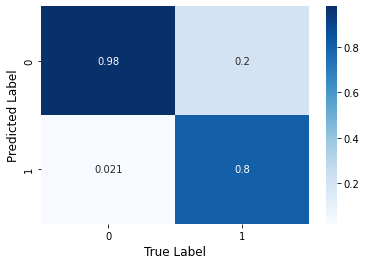

In [81]:
# Confusion Matrix
plot_confusion_matrix()

# TP 0.99 TN 0.83

In [82]:
predicted_val_logi = logi.predict_proba(test)[:, 1]
winner_lg = pd.concat([BB_telugu_participant, pd.DataFrame(predicted_val_logi, columns=['Predicted_Winner'])],axis=1)
winner_lg.sort_values('Predicted_Winner', ascending=False)

,Name,Predicted_Winner
0,Ajay Kumar,0.001333
7,Mahesh Vitta,0.001333
8,Mitraaw Sharma,0.001187
3,Ariyana Glory,0.000902
1,Akhil Sarthak,0.000542
10,Shiva,0.000375
5,Bindu Madhavi,0.000317
6,Hamida Khatoon,0.000241
11,Sravanthi,0.000195
4,Ashu Reddy,0.000175


## Predicted Winner for Bigg Boss Telugu Non-Stop Season, as per Logistic Regression

In [83]:
# Predicted Winner for Bigg Boss Telugu Season Non-Stop, as per LogisticRegression
winner_lg[winner_lg['Predicted_Winner'] == np.amax(winner_lg.Predicted_Winner)]

,Name,Predicted_Winner
0,Ajay Kumar,0.001333
7,Mahesh Vitta,0.001333


In [84]:
# Random Forest
rf = RandomForestClassifier(n_estimators=5000, random_state=2022).fit(x_train, y_train)
rf

RandomForestClassifier(n_estimators=5000, random_state=2022)

In [85]:
predicted_val_rf = rf.predict_proba(x_val)[:, 1]
y_predicted_val = (predicted_val_rf > 0.3).astype("int").ravel()
print('F1 Score -', f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -', accuracy_score(y_val, y_predicted_val)*100)

# n_estimators=500 accuracy 98.5
# n_estimators=1000 accuracy 99.00

F1 Score - 98.98477157360406
Accuracy Score - 98.98477157360406


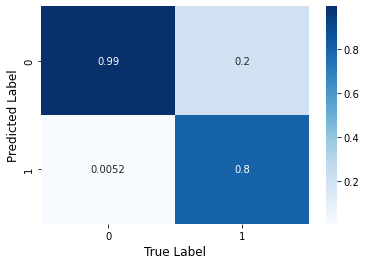

In [86]:
# Confusion Matrix
plot_confusion_matrix()

# TP 1 TN 0.7

In [87]:
predicted_val_rf = rf.predict_proba(test)[:, 1]
winner_rf = pd.concat([BB_telugu_participant, pd.DataFrame(predicted_val_rf, columns=['Predicted_Winner'])], axis=1)
winner_rf.sort_values('Predicted_Winner', ascending=False)

,Name,Predicted_Winner
3,Ariyana Glory,0.0194
8,Mitraaw Sharma,0.0138
0,Ajay Kumar,0.0100
7,Mahesh Vitta,0.0100
10,Shiva,0.0078
1,Akhil Sarthak,0.0042
2,Anil Rathod,0.0010
9,Nataraj,0.0008
11,Sravanthi,0.0008
12,Tejaswi Madivada,0.0002


## Predicted Winner for Bigg Boss Telugu Season Non-Stop, as per Random Forest

In [88]:
# Predicted Winner for Bigg Boss Telugu Non-Stop Season, as per RandomForest
winner_rf[winner_rf['Predicted_Winner'] == np.amax(winner_rf.Predicted_Winner)]

,Name,Predicted_Winner
3,Ariyana Glory,0.0194


## Machine Learning (ML) models to predict Indian BiggBoss (Big Brother) season Winners

## Hindi Bigg Boss Season15
## https://www.kaggle.com/thirumani/predicting-bigg-boss-hindi-season-15-winner

## Kannada Bigg Boss Season9
## https://www.kaggle.com/thirumani/predicting-bigg-boss-kannada-season-9-winner

## Tamil Bigg Boss Ultimate Season
## https://www.kaggle.com/thirumani/predicting-bigg-boss-tamil-ultimate-season-winner

## Malayalam Bigg Boss Season4
## https://www.kaggle.com/thirumani/predicting-bigg-boss-malayalam-season-4-winner

## Marathi Bigg Boss Season3
## https://www.kaggle.com/thirumani/predicting-bigg-boss-marathi-season-3-winner

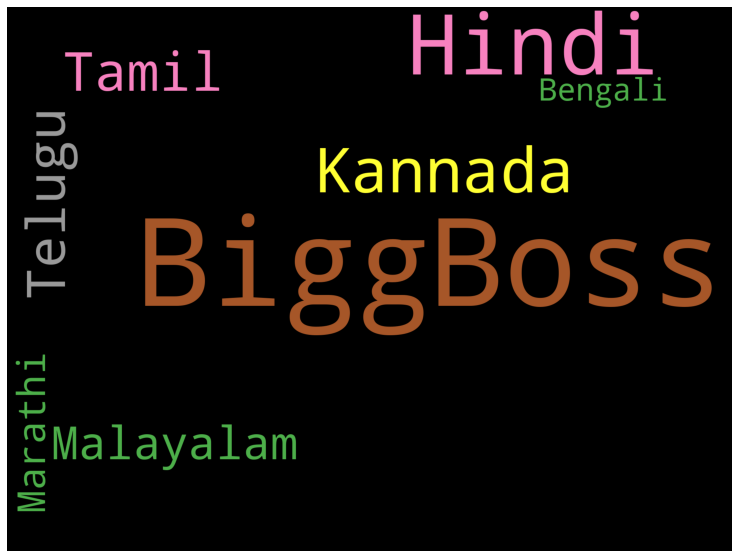

In [89]:
# Word cloud of Bigg Boss
text = " BiggBoss ".join(cat for cat in bigg_boss['Language'])
wordcloud = WordCloud(width=2000, height=1500, background_color='Black', colormap='Set1', collocations=False, random_state=2022).generate(text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

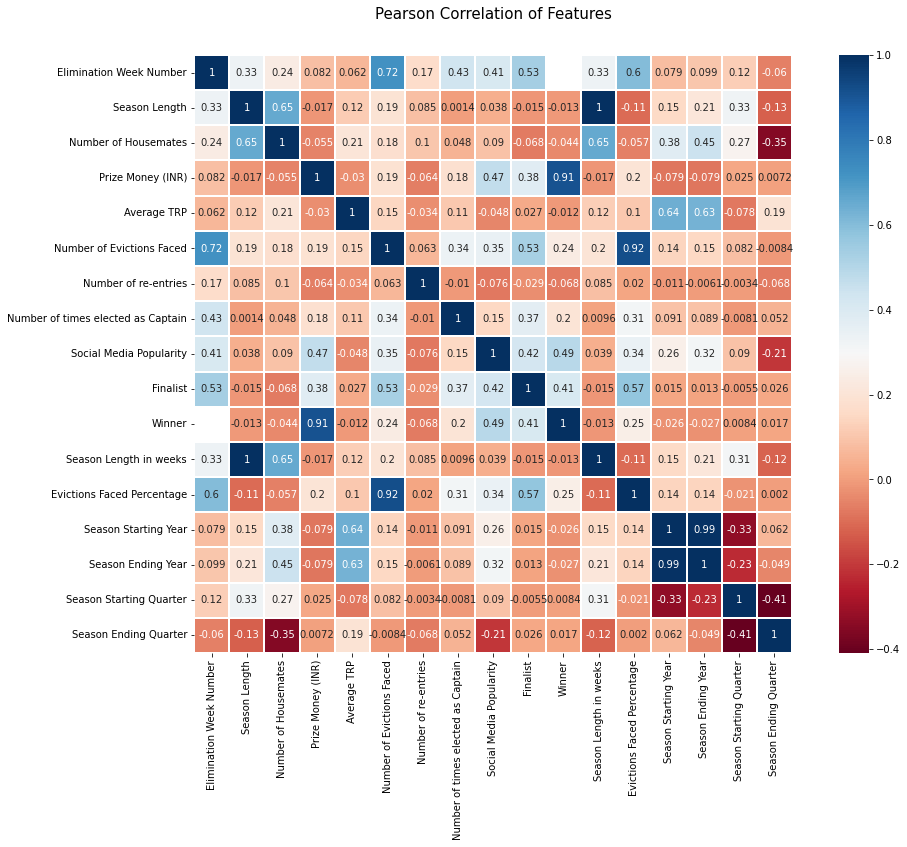

In [90]:
# Correlation matrix (Heatmap style)
corrmat = bigg_boss.corr()
f, ax = plt.subplots(figsize=(17, 11))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(corrmat, vmax=1.0, linewidths=0.1, square=True, cmap="RdBu", linecolor='white', annot=True);

In [91]:
# Crosschecking Actor/Actress Gender
bigg_boss[bigg_boss['Profession'].str.contains('Act')].groupby('Gender')['Profession'].value_counts().unstack()
#bigg_boss.loc[(bigg_boss['Profession']=='Actress') & (bigg_boss['Gender']=='Male')]

Profession,Activist,Actor,Actor & Actress,Actress,Soap Actor,Soap Actress,Stage Actress
Gender,,,,,,,
Couple,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Female,4.0,NaN,NaN,180.0,NaN,67.0,2.0
Male,4.0,133.0,NaN,NaN,42.0,NaN,NaN


In [92]:
print("numpy version: {}". format(np.__version__))
print("pandas version: {}". format(pd.__version__))
import matplotlib
print("matplotlib version: {}". format(matplotlib. __version__))
print("seaborn version: {}". format(sns.__version__))
import sklearn
print("sklearn version: {}". format(sklearn.__version__))
import plotly
print("plotly version: {}". format(plotly.__version__))

# Current versions
# numpy version: 1.20.3
# pandas version: 1.3.5
# matplotlib version: 3.5.1
# seaborn version: 0.11.2
# sklearn version: 1.0.1
# plotly version: 5.6.0

numpy version: 1.20.3
pandas version: 1.3.5
matplotlib version: 3.5.1
seaborn version: 0.11.2
sklearn version: 1.0.1
plotly version: 5.6.0
